## Text Generation using a Recurrent Neural Network and Long Short-Term Memory model
### I will be using a model trained on the first two scenes of Act 1 of William Shakespeare's <i>The Tempest</i> to generate text. This text is public domain, downloaded from the following website: https://www.folger.edu/explore/shakespeares-works/the-tempest/read/1/1/ 
### NLP libraries used: SpaCy and NLTK
### NLP topics used: removing stopwords, NER, POS, stemming, lemmatization, WordCloud
### NLP application used: Text generation
![title](pic/Tempest.jpg)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import warnings and ignore them
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import spacy
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Exploratory Data Analysis

In [2]:
# Load the dataset
file_path = 'data/The_Tempest.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

In [3]:
# Read the text file into a Pandas DataFrame
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Creating a DataFrame with the text content
df = pd.DataFrame({'Text': lines})

# Displaying the first 10 rows
print(df.head(10))

                                                Text
0                                   Act 1, scene 1\n
1                                          Scene 1\n
2                                                 \n
3                                        Synopsis:\n
4                                                 \n
5  On board a ship carrying King Alonso of Naples...
6                                                 \n
7  A tempestuous noise of thunder and lightning h...
8              Enter a Shipmaster and a Boatswain.\n
9                                                 \n


In [4]:
# Get information about the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    798 non-null    object
dtypes: object(1)
memory usage: 6.4+ KB
None


In [5]:
# Describe the DataFrame
print(df.describe())

       Text
count   798
unique  726
top      \n
freq     32


### NLP technique: removing stopwords

In [6]:
# Combine all text into a single string
all_text = ' '.join(df['Text'])

# Tokenize text into words
words = re.findall(r'\w+', all_text.lower())  # Extract words

# Get NLTK English stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords from words list
filtered_words = [word for word in words if word not in stop_words]

# Count word frequency
word_counts = Counter(filtered_words)

# Get top 10 most frequent words
top_10_words = word_counts.most_common(10)

# Display top 10 words
print(top_10_words)

[('thou', 84), ('prospero', 73), ('miranda', 50), ('thee', 44), ('ariel', 41), ('th', 32), ('thy', 31), ('st', 24), ('ferdinand', 23), ('sir', 18)]


### Visualizing the top 10 most common words in the text (after removing stopwords)

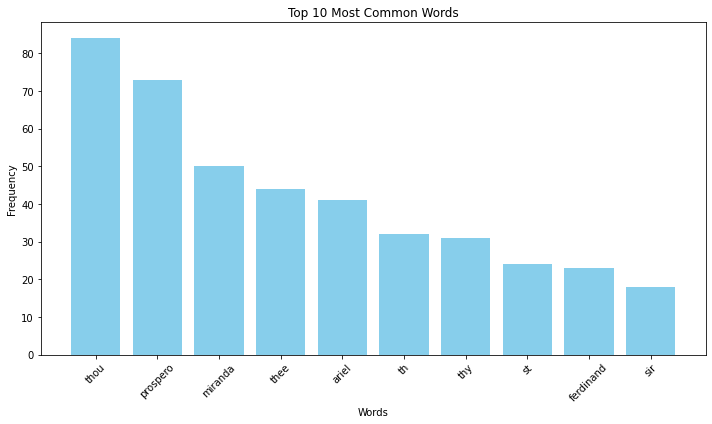

In [7]:
# Extract words and their counts separately
words = [pair[0] for pair in top_10_words]
counts = [pair[1] for pair in top_10_words]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

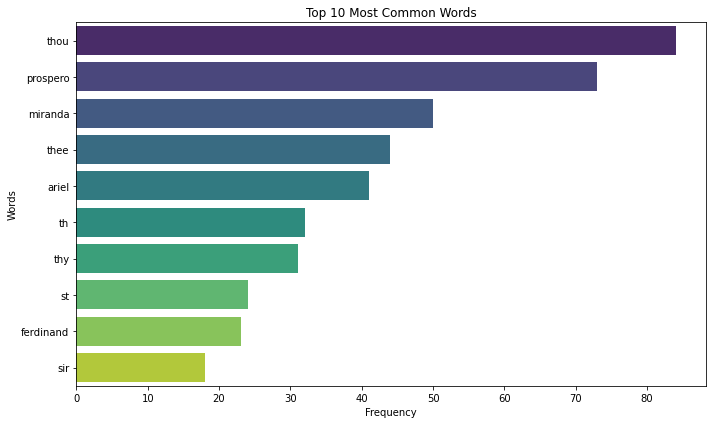

In [8]:
# Extract words and their counts separately
words = [pair[0] for pair in top_10_words]
counts = [pair[1] for pair in top_10_words]

# Plotting the bar graph using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 10 Most Common Words')
plt.tight_layout()

# Show the plot
plt.show()

### NLP technique: WordCloud

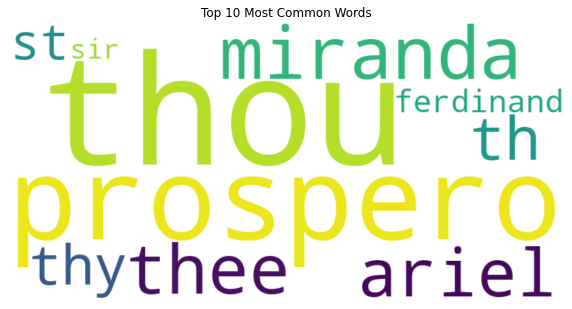

In [9]:
# Generate a dictionary with words and their frequencies
word_freq = {word: freq for word, freq in top_10_words}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 10 Most Common Words')
plt.show()

### NLP technique: Named Entity Recognition (NER) tags

In [10]:
# Load SpaCy's English model
nlp = spacy.load('en_core_web_sm')

# Extract the first 50 lines of text
lines = all_text.split('\n')[:50]
text_subset = '\n'.join(lines)

# Perform NER on the subset of text
doc = nlp(text_subset)

# Extract entities and their labels
entities = [(ent.text, ent.label_) for ent in doc.ents]

# Display the extracted entities and their labels
print(entities)

[('Act 1', 'LAW'), ('1', 'CARDINAL'), ('Alonso', 'PERSON'), ('Naples', 'GPE'), ('Shipmaster', 'NORP'), ('Boatswain', 'ORG'), ('Bestir', 'GPE'), ('BOATSWAIN  Heigh', 'ORG'), ('Yare', 'ORG'), ('Alonso', 'PERSON'), ('Sebastian', 'PERSON'), ('Antonio', 'GPE'), ('Ferdinand', 'GPE'), ('Gonzalo', 'GPE'), ('GONZALO  Nay', 'ORG'), ('GONZALO', 'ORG'), ('thou hast\n aboard', 'PERSON')]


### NLP technique: Parts-of-Speech (POS) tags

In [11]:
# Load SpaCy's English model
nlp = spacy.load('en_core_web_sm')

# Extract the first 50 lines of text
lines = all_text.split('\n')[:50]
text_subset = '\n'.join(lines)

# Process the subset of text
doc = nlp(text_subset)

# Display tokens and their POS tags
for token in doc:
    print(f"{token.text:15} : {token.pos_}")

Act             : PROPN
1               : NUM
,               : PUNCT
scene           : NOUN
1               : NUM

               : SPACE
Scene           : PROPN
1               : NUM

 
             : SPACE
Synopsis        : NOUN
:               : PUNCT

 
             : SPACE
On              : ADP
board           : NOUN
a               : DET
ship            : NOUN
carrying        : VERB
King            : PROPN
Alonso          : PROPN
of              : ADP
Naples          : PROPN
and             : CCONJ
his             : PRON
entourage       : NOUN
,               : PUNCT
a               : DET
boatswain       : NOUN
directs         : VERB
the             : DET
crew            : NOUN
to              : PART
fight           : VERB
a               : DET
great           : ADJ
storm           : NOUN
,               : PUNCT
but             : CCONJ
the             : DET
ship            : NOUN
appears         : VERB
destined        : VERB
to              : PART
sink            : VERB
.       

### NLP techniques: Stemming and Lemmatization

In [12]:
# Initialize SpaCy's English model
nlp = spacy.load('en_core_web_sm')

# Import the Porter Stemmer from NLTK
stemmer = PorterStemmer()

# Perform stemming on the top 10 words
stemmed_words = [stemmer.stem(word[0]) for word in top_10_words]

# Print the stemmed words
print(stemmed_words)

# Re-initialize SpaCy's English model (redundant as it's already initialized above)
nlp = spacy.load('en_core_web_sm')

# Perform lemmatization using SpaCy on the top 10 words
lemmatized_words = [nlp(word[0])[0].lemma_ for word in top_10_words]

# Print the lemmatized words
print(lemmatized_words)

['thou', 'prospero', 'miranda', 'thee', 'ariel', 'th', 'thi', 'st', 'ferdinand', 'sir']
['thou', 'prospero', 'miranda', 'thee', 'ariel', 'th', 'thy', 'st', 'ferdinand', 'sir']


### NLP technique: word tokenization

In [13]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1

### Building the model used for text generation

In [14]:
# Create input sequences and corresponding labels
input_sequences = []
# Generate input sequences for each line in the text
for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        # Create n-gram sequences of tokens and append them to input_sequences
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [15]:
# Determine the maximum sequence length among all input sequences
max_sequence_length = max([len(x) for x in input_sequences])

# Pad input sequences to make them uniform in length
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')
X, y = input_sequences[:, :-1], input_sequences[:, -1]

# Convert labels to one-hot encoded format
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

In [16]:
# Build the LSTM model
# The model will be a sequential model
model = Sequential()
# The first input layer will be an embedding layer
model.add(Embedding(total_words, 50, input_length=max_sequence_length-1))
# The second input layer will be a long short-term memory layer
model.add(LSTM(100))
# The third layer will be a dense layer 
model.add(Dense(total_words, activation='softmax'))
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Showing a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 167, 50)           73950     
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 1479)              149379    
                                                                 
Total params: 283,729
Trainable params: 283,729
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Train the model
model.fit(X, y, epochs=100, verbose=1)

Epoch 1/100
138/138 [==============================] - 5s 33ms/step - loss: 6.7881 - accuracy: 0.0262
Epoch 2/100
138/138 [==============================] - 4s 32ms/step - loss: 6.3378 - accuracy: 0.0268
Epoch 3/100
138/138 [==============================] - 4s 31ms/step - loss: 6.2141 - accuracy: 0.0291
Epoch 4/100
138/138 [==============================] - 4s 31ms/step - loss: 6.1331 - accuracy: 0.0291
Epoch 5/100
138/138 [==============================] - 4s 32ms/step - loss: 6.0553 - accuracy: 0.0355
Epoch 6/100
138/138 [==============================] - 4s 31ms/step - loss: 5.9767 - accuracy: 0.0373
Epoch 7/100
138/138 [==============================] - 4s 31ms/step - loss: 5.8926 - accuracy: 0.0364 0s - loss: 5.9011 - accu
Epoch 8/100
138/138 [==============================] - 4s 32ms/step - loss: 5.8122 - accuracy: 0.0412
Epoch 9/100
138/138 [==============================] - 4s 32ms/step - loss: 5.7347 - accuracy: 0.0421
Epoch 10/100
138/138 [==============================] - 4

138/138 [==============================] - 4s 32ms/step - loss: 1.0839 - accuracy: 0.7705
Epoch 81/100
138/138 [==============================] - 4s 31ms/step - loss: 1.0600 - accuracy: 0.7798
Epoch 82/100
138/138 [==============================] - 4s 32ms/step - loss: 1.0383 - accuracy: 0.7841
Epoch 83/100
138/138 [==============================] - 4s 32ms/step - loss: 1.0309 - accuracy: 0.7828
Epoch 84/100
138/138 [==============================] - 4s 32ms/step - loss: 0.9969 - accuracy: 0.7907
Epoch 85/100
138/138 [==============================] - 4s 31ms/step - loss: 0.9736 - accuracy: 0.7971
Epoch 86/100
138/138 [==============================] - 4s 32ms/step - loss: 0.9536 - accuracy: 0.8014
Epoch 87/100
138/138 [==============================] - 4s 32ms/step - loss: 0.9343 - accuracy: 0.8046
Epoch 88/100
138/138 [==============================] - 4s 31ms/step - loss: 0.9159 - accuracy: 0.8078
Epoch 89/100
138/138 [==============================] - 4s 32ms/step - loss: 0.8976 - 

In [18]:
# Function to generate text
def generate_text(seed_text, next_words, model, max_sequence_length):
    # Loop for the number of words to generate
    for _ in range(next_words):
        # Tokenize the seed text to convert it into a sequence of tokens
        token_list = tokenizer.texts_to_sequences([seed_text])[0] # tokenizing the seed text
        
        # Pad the token list to match the required sequence length for the model input
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre') # padding
        
        # Use the model to predict the index of the next word in the sequence
        predicted = np.argmax(model.predict(token_list, verbose=0)) 
        
        # Map the predicted index back to the corresponding word using the tokenizer's word_index
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        
        # Append the predicted word to the seed text for the next iteration
        seed_text += " " + output_word
    
    # Return the generated text based on the seed text and the predicted words
    return seed_text

In [19]:
# Generate pre-programmed text based on the model
generated_text = generate_text("On board a ship", 20, model, max_sequence_length)
print(generated_text)

On board a ship carrying king and played it miranda but business on the barren island for twelve years with his daughter miranda explains


In [20]:
# Defining a function that will take user input and prompt the user for how many words they would like to generate
def generate_text_from_input(model, max_sequence_length):
    user_input = input("Enter starting text: ")  # Prompt the user for initial text
    seed_text = user_input.lower()  # Convert to lowercase (assuming case insensitivity)
    
    # Prompt the user for additional words
    additional_words = input("Enter three additional words separated by spaces: ")
    additional_words = additional_words.lower().split()  # Split the words
    
    # Add the additional words to the seed text
    seed_text += " " + " ".join(additional_words)
    
    # Prompt the user for the number of words to generate
    num_words = int(input("Enter the number of words to generate: "))
    
    # Generate text using the provided seed text and the model
    generated_text = generate_text(seed_text, num_words, model, max_sequence_length)
    return generated_text

In [21]:
# Run the above function to take input from a user
generated_text = generate_text_from_input(model, max_sequence_length)
print(generated_text)

Enter starting text: Prospero
Enter three additional words separated by spaces: boards a ship
Enter the number of words to generate: 50
prospero boards a ship carrying king and envy up home for his memory ariel hears ariel’s report of the tempest and gives him further orders prospero wakes miranda and they visit caliban whom prospero threatens with torture if he will not continue his labors ariel invisible entices ferdinand son and heir to alonso into


### Summary and Conclusion

### The model used for text generation after running for 100 epochs had an accuracy of about 83%. Upon running the function with 20 words without asking for user input, the text that was generated more or less makes sense, but running the function asking for user input and testing it by asking for 50 words to generate seems to have generated text that appears to make less sense.  It appears that the model seems less accurate the more words it is asked to generate. This could be an issue of the model being too simple. Tuning the hyperparameters used in the model may result in a more accurate model, as well as running for more epochs, which will generate text that should make more sense to the reader.